In [1]:
# %%writefile Ind_Behavior.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tools.Sample_Tools as smpl

from base.JuUnits import excute_for_multidates

from sklearn import linear_model


In [58]:
def cal_ret_market(market_value,ret_excess_data):
    '''计算市场（平均）收益
        :param market_value：{pd.Series} --市值
        :param ret_excess_data：{pd.Series} --超额回报
        
        :return: {pd.Series}  -- 市值加权的市场平均收益
    '''
    ##  不取对数有时候有精度问题,权重不是精确1
    market_value_log = np.log(market_value)
    weight = market_value_log / market_value_log.sum()
    ret_market_f = (ret_excess_data * weight).sum()
    return ret_market_f
'''
    需要准备的基础数据
    stock_df = load_cache('all_train_qfq',cache_type=CACHE_TYPE.STOCK).sort_index()
    smpl.optimize_data_type(stock_df)
    # stock_df = pd.concat(list(map(lambda file:load_cache(file,cache_type=CACHE_TYPE.STOCK),['all_train_qfq','all_tail_qfq','all_older_qfq']))).sort_index()

    ## 日无风险回报
    ret_fs_data = pd.read_csv(module_path+'/data/static/china10yearbond.csv').set_index('date').sort_index()
    ret_fs_data = (ret_fs_data['high'].astype(np.float32)+ret_fs_data['low'].astype(np.float32))/2 * 0.01
    ret_fs_daily = ret_fs_data/252
'''

def prepare_data(stock_df,ret_fs):
    '''数据准备
        :param stock_df：{pd.DataFrame} --股票数据，包含close,volume,market_value，liquidity_market_value,industry
        :param ret_fs：{pd.Series} --无风险回报
        
        :return: {set in [ret_t,ret_t_excess,market_value_t,ret_excess_market_t]}
    '''

    ret_t = smpl.get_current_return(stock_df,'close')
    ret_t.name = 'ret'

    # 超额回报
    ret_t_excess = ret_t.groupby(pd.Grouper(level='date', freq='1M')).apply(
            lambda x:(x-ret_fs.get(x.index[0][0].strftime('%Y-%m'),default=ret_fs[-1])))
    ret_t_excess.name = 'ret_excess'
    
    # 市值
    market_value_t = stock_df['market_value']
    market_value_t.name = 'market_value'

    # 市场收益，日内全市场收益加权平均
    ret_excess_market_t = excute_for_multidates(ret_t_excess,
                                         lambda ret: cal_ret_market(market_value_t.loc[ret.index[0][0]],ret), 
                                         level=0)
    ret_excess_market_t.name = 'ret_excess_market'
    
    return ret_t, ret_t_excess, market_value_t, ret_excess_market_t

In [59]:
from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)
stock_df = load_cache('all_train_qfq',cache_type=CACHE_TYPE.STOCK).sort_index()
smpl.optimize_data_type(stock_df)
# stock_df = pd.concat(list(map(lambda file:load_cache(file,cache_type=CACHE_TYPE.STOCK),['all_train_qfq','all_tail_qfq','all_older_qfq']))).sort_index()

## 日无风险回报
ret_fs_data = pd.read_csv(module_path+'/data/static/china10yearbond.csv').set_index('date').sort_index()
ret_fs_data = (ret_fs_data['high'].astype(np.float32)+ret_fs_data['low'].astype(np.float32))/2 * 0.01
ret_fs_daily = ret_fs_data/252


ret_t, ret_t_excess, market_value_t, ret_excess_market_t = prepare_data(stock_df,ret_fs_daily)



In [4]:
def sizelg(stock_data):
    '''市值因子
        :param stock_data：{pd.DataFrame} --需要包含market_value
    '''
    mv = np.log(stock_data['market_value'])
    mv.name = 'sizelg'
    return mv

def bp(stock_data):
    '''Book-to-Price
        :param stock_data：{pd.DataFrame} --需要包含close
    '''
    data = smpl.add_report_inds(stock_data[['close']],'netAssetsPerShare')
    bp = data['close']/data['netAssetsPerShare']
    bp.name = 'bp'
    return bp

In [207]:
# ret_excess_market_t
# size_ = sizelg(stock_df)
# bp_ = bp(stock_df)

# 因子收益率为样本空间内因子值最小的 1/3 股票构建的流通市值加权组合与最大 1/3 股票组合收益率之差。

# # 市值因子收益率
# def calc_SMB(x):
#     bin_labels = pd.qcut(x['sizelg'],[0, 0.3, 0.7, 1],labels=[0,1,2])
#     return x['ret'][bin_labels==2].sum()-x['ret'][bin_labels==0].sum()

# SMB = pd.concat([ret_t,size_],axis=1).dropna().groupby(level=0).apply(lambda x:calc_SMB(x))

# # 估值因子收益率
# def calc_HML(x):
#     bin_labels = pd.qcut(x['bp'],[0, 0.3, 0.7, 1],labels=[0,1,2])
#     return x['ret'][bin_labels==2].sum()-x['ret'][bin_labels==0].sum()
# HML = pd.concat([ret_t,bp_],axis=1).dropna().groupby(level=0).apply(lambda x:calc_HML(x))


# ret_exce = alpha + b_1*(ret_mk_exce)+b_2*SMB+b_3*HML + epsilon
# 市场收益率、市值因子收益率、估值因子收益率

# def calc_residual(xs,y):
#     y_ = y.dropna()
#     y_mat = y_.values.reshape(-1, 1)
#     x_mat = np.repeat(xs.values , y_mat.shape[0], axis=0)
#     model = linear_model.LinearRegression(fit_intercept=True)  
#     resualt = model.fit(x_mat, y_mat)
#     residual = pd.Series((y_mat-resualt.predict(x_mat)).squeeze(),index=y_.index)
#     return residual
    
# # xs_df = pd.concat([ret_excess_market_t.loc[SMB.index],SMB,HML],axis=1)

# residuals_df = excute_for_multidates(xs_df,
#                                  lambda xs: calc_residual(xs,ret_t_excess.loc[xs.index]), 
#                                  level=0)
# 特质波动
ivol_window = 22
# corrects = np.sqrt(22)  #model是当日的，可以理解为非月截面，无需sqrt(N)？
ivol = excute_for_multidates(residuals_df,
                            lambda ts: ts.rolling(ivol_window).apply(lambda x:x.std(ddof=1) ), 
                            level=1)

ivol


# size_

date        code  
2016-01-05  000001         NaN
            000006         NaN
            000008         NaN
            000009         NaN
            000010         NaN
                        ...   
2020-12-31  605376         NaN
            605377         NaN
            605388    0.055003
            605399    0.020398
            605500         NaN
Length: 3020035, dtype: float64

In [205]:
residuals_df.loc["2020-11-02":"2020-12-31"].loc[(slice(None),['000001','605388'])]

date        code  
2020-11-02  000001   -0.005058
            605388    0.004538
2020-11-03  000001   -0.000219
            605388    0.007081
2020-11-04  000001    0.021134
                        ...   
2020-12-29  605388   -0.046263
2020-12-30  000001   -0.003968
            605388    0.053291
2020-12-31  000001   -0.004947
            605388   -0.025466
Length: 88, dtype: float64

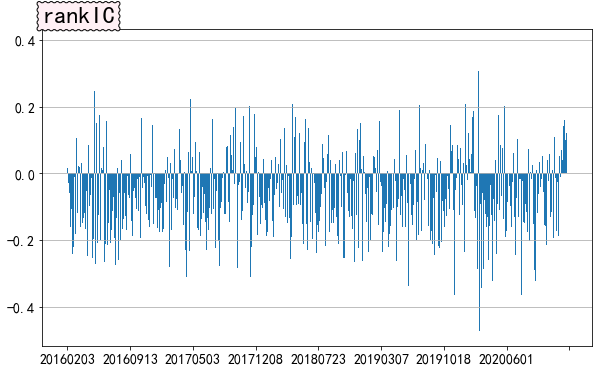

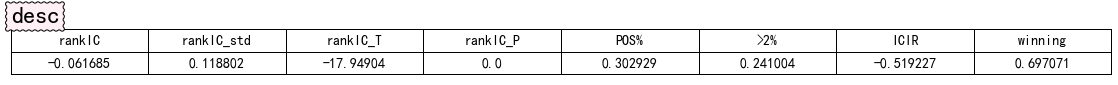

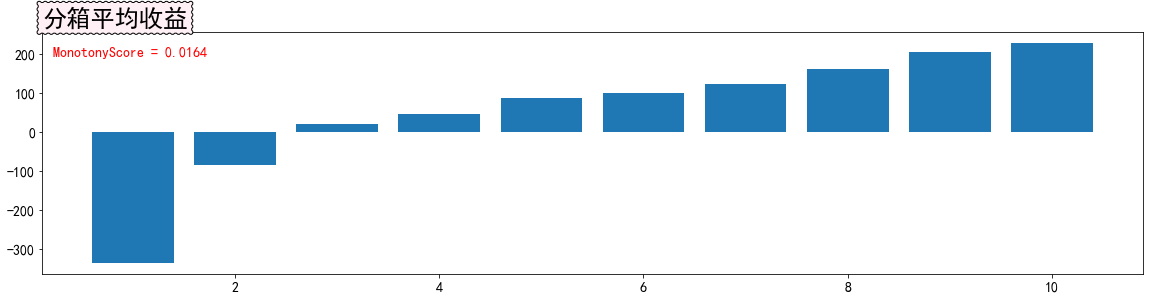

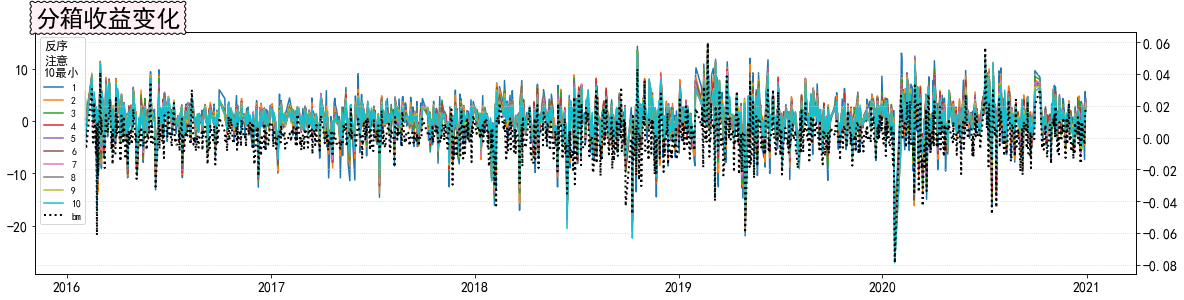

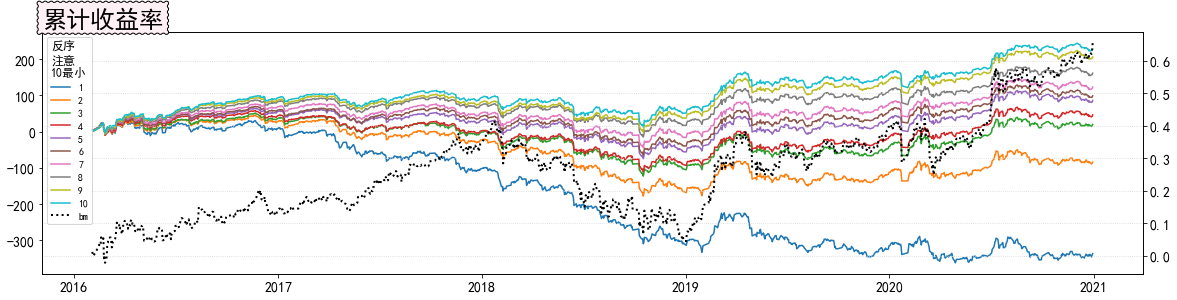

Wall time: 1min 57s


In [210]:
%%time
from tools.Test_Tools_Simple import FactorTest

# %load_ext autoreload
# %autoreload 1
# %aimport tools.Test_Tools_Simple




ret = smpl.get_forward_return(stock_df,'close')

fa = pd.DataFrame(ivol).dropna()
dates = fa.index.get_level_values(0).unique()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()


In [ ]:

# ivol = epsilon.std(ddof=1) * sqrt(N) 
# SMB

# HML

# r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2

# 特异度 1-r2 
# 特质波动=sqrt（特异度）*总波动率 ？？？

# ln(turnover) = alpha + b* ln(mv)+epsilon
# 回归残差项我们用来作为剔除市值后的换手率代理变量，我们称之为流通市值调整换手。


In [ ]:
# behaviorIndex = 1/2*[Q(IVR)+Q(adjTurnover)]
# behaviorIndex为股票i在时刻t的交易热度，IVR为股票i在时刻t的特异度，adjTurnover为股票i在时刻t的市值调整换手。
# Q表示股票i的指标在时刻t样本空间内所有股票中所对应的分位数（累计分布概率）。
# 根据交易热度的定义可知，交易热度的取值在0-1之间，交易热度取值越高，表明股票交易的活跃程度越高，反应的投机程度越大，后期预期收益率越低。